# 2000 year reconstructions: Brennan et al 2020 comparison

## Figure 3 & Table 1

July 2020  
Katie Brennan  

In [1]:
import sys,os,copy

In [7]:
import sys
import numpy as np
import pickle
import xarray as xr 

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [12]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

In [13]:
plt.rcParams['figure.dpi']=500

In [56]:
 def load_bren2020_full(): 
    data_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/Brennan_etal_2020/data/'
    filename = 'Brennan_etal_2020_sie_recons.nc'

    import xarray as xr

    data_bren2020 = xr.open_dataset(data_dir+filename)
    
    return data_bren2020

def load_bren2020_data(mod_list,temp_list):
    """INPUTS:
       mod_list = list of strings, all caps (ex: ['MPI','CCSM4'])
       temp_list = list of temperature datasets (ex: ['HadCRUT4','Berkeley_Earth','GISTEMP'])
    """
    data_bren2020 = load_bren2020_full()
    sie_bren2020 = {}
    sie_97_5_bren2020 = {}
    sie_2_5_bren2020 = {}
    
    for m in mod_list: 
        for d in temp_list: 
            sie_name = 'sie_'+m+'_'+d
            bren2020_time = data_bren2020[sie_name][d+'_time'].values
            sie_bren2020[sie_name] = np.nanmean(np.reshape(data_bren2020[sie_name].values,(169,1000)),axis=1)
            sie_97_5_bren2020[sie_name+'_97_5'] = data_bren2020[sie_name+'_97_5'].values
            sie_2_5_bren2020[sie_name+'_2_5'] = data_bren2020[sie_name+'_2_5'].values
            
    return bren2020_time, sie_bren2020, sie_97_5_bren2020, sie_2_5_bren2020


def load_annual_satellite(): 
    """Loads annual satellite data and finds anomalies that start at 1979 and go 
       to ANOM_END. 
    """
    # Import satellite data Fetterer v3: 
    fet_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/Fetterer_v3/'
    #fet_file = 'Fetterer_data_v3_annual_1978_2017.npz'
    fet_file = 'Fetterer_data_v3_annual_78_17.npz'

    # Load annual data
    fet_loc = fet_directory + fet_file
    fet_data = np.load(fet_loc)

    fet_sie = fet_data['si_extent']
    fet_sia = fet_data['si_area']
    fet_time = fet_data['time']
    
    return fet_sia, fet_sie, fet_time

def find_anomalies(TIME, VAR, ANOM_START, ANOM_END, mean=False):
    """Finds anomalies between (and including) ANOM_START and ANOM_END. 
       inputs: 
       TIME = array of years (time) 
       VAR = variable to take anomalies of (time)
       ANOM_START = year anomaly period starts
       ANOM_END = year anomaly period ends (included) 
    """
   
    gt = np.where(TIME>=ANOM_START)
    lt = np.where(TIME<=ANOM_END)
    
    VAR_mean = np.nanmean(VAR[gt[0].min():lt[0].max()],axis=0)
    VAR_anom = VAR - VAR_mean
    
    if mean is True: 
        return VAR_anom, VAR_mean
    else: 
        return VAR_anom
    
def find_ce_corr(VAR, REF, REF_TIME, VAR_TIME, START_TIME, END_TIME, detrend=False):
    """Finds the correlation coefficient and coefficient of efficiency between 
       REF and VAR between START_TIME and END_TIME.
       inputs: 
           VAR = test data (1D in time)
           REF = reference data (1D in time) 
           REF_time = reference data time (1D time)
           VAR_TIME = test data time (1D years)
           START_TIME = comparison start year to be included (float)
           END_TIME = last year included in comparison (float)
       
    """
    yr_range_var = np.where((VAR_TIME>=START_TIME)&(VAR_TIME<END_TIME+1))
    yr_range_ref = np.where((REF_TIME>=START_TIME)&(REF_TIME<END_TIME+1))
    
    if detrend is False: 
        ref = REF[yr_range_ref[0]]
        var = VAR[yr_range_var[0]]
    else: 
        ref = spy.detrend(REF[yr_range_ref])
        var = spy.detrend(VAR[yr_range_var])
        
    ce = coefficient_efficiency(ref,var)
    corr = np.corrcoef(ref,var)[0,1]
    var_ref = np.var(ref)
    var_var = np.var(var)
    
    return ce, corr,var_ref,var_var

def coefficient_efficiency(ref,test,valid=None):
    """
    ***Copied from LMR_utils.py 04/08/20***
    Compute the coefficient of efficiency for a test time series, 
    with respect to a reference time series.

    Inputs:
    test:  test array
    ref:   reference array, of same size as test
    valid: fraction of valid data required to calculate the statistic 

    Note: Assumes that the first dimension in test and ref arrays is time!!!

    Outputs:
    CE: CE statistic calculated following Nash & Sutcliffe (1970)
    """

    # check array dimensions
    dims_test = test.shape
    dims_ref  = ref.shape
    #print('dims_test: ', dims_test, ' dims_ref: ', dims_ref)

    if len(dims_ref) == 3:   # 3D: time + 2D spatial
        dims = dims_ref[1:3]
    elif len(dims_ref) == 2: # 2D: time + 1D spatial
        dims = dims_ref[1:2]
    elif len(dims_ref) == 1: # 0D: time series
        dims = 1
    else:
        print('In coefficient_efficiency(): Problem with input array dimension! Exiting...')
        SystemExit(1)

    CE = np.zeros(dims)

    # error
    error = test - ref

    # CE
    numer = np.nansum(np.power(error,2),axis=0)
    denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
    CE    = 1. - np.divide(numer,denom)

    if valid:
        nbok  = np.sum(np.isfinite(ref),axis=0)
        nball = float(dims_ref[0])
        ratio = np.divide(nbok,nball)
        indok  = np.where(ratio >= valid)
        indbad = np.where(ratio < valid)
        dim_indbad = len(indbad)
        testlist = [indbad[k].size for k in range(dim_indbad)]
        if not all(v == 0 for v in testlist):
            if isinstance(dims,(tuple,list)):
                CE[indbad] = np.nan
            else:
                CE = np.nan

    return CE

def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [57]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

## Load reconstructions: 

In [15]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
#output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'
output_file_ccsm4 = 'sic_ccsm4_anrecon_revisions1_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years, 
 proxy_assim_loc_allit_ccsm4] = ce_utils.load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [16]:
output_dir_mpi = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
#output_file_mpi = 'sic_mpi_anrecon_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'
output_file_mpi = 'sic_mpi_anrecon_revisions1_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_mpi, tas_lalo_allit_mpi, sic_ens_var_allit_mpi, 
 nobs_allit_mpi, sia_ens_allit_mpi, sie_ens_allit_mpi, Ye_assim_allit_mpi, 
 Ye_assim_coords_allit_mpi, Xb_inflate_allit_mpi, recon_years, 
 proxy_assim_loc_allit_mpi] = ce_utils.load_recon_allit(output_dir_mpi,output_file_mpi,niter)

## Load comparison datasets: 

In [17]:
anom_start = 1979
anom_end = 2000

In [18]:
# LOAD BRENNAN ET AL 2020 DATA: 
[bren2020_time, sie_bren2020, 
 sie_97_5_bren2020, sie_2_5_bren2020] = load_bren2020_data(['CCSM4','MPI'],['HadCRUT4'])

# adjust anomalies: 
time_inds = np.where((bren2020_time<anom_end)&(bren2020_time>anom_start-1))

sie_bren2020['sie_MPI_HadCRUT4_anom'] = (sie_bren2020['sie_MPI_HadCRUT4']-
                                         np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_bren2020['sie_CCSM4_HadCRUT4_anom'] = (sie_bren2020['sie_CCSM4_HadCRUT4']-
                                           np.nanmean(sie_bren2020['sie_CCSM4_HadCRUT4'][time_inds]))
sie_MPI_HadCRUT4_97_5_anom = (sie_97_5_bren2020['sie_MPI_HadCRUT4_97_5']-
                              np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_CCSM4_HadCRUT4_97_5_anom =  (sie_97_5_bren2020['sie_CCSM4_HadCRUT4_97_5']-
                                 np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_MPI_HadCRUT4_2_5_anom = (sie_2_5_bren2020['sie_MPI_HadCRUT4_2_5']-
                             np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_CCSM4_HadCRUT4_2_5_anom =  (sie_2_5_bren2020['sie_CCSM4_HadCRUT4_2_5']-
                                np.nanmean(sie_bren2020['sie_CCSM4_HadCRUT4'][time_inds]))

In [19]:
# LOAD ANNUAL SATELLITE DATA: 
[fet_sia_anom, fet_sia_anom_adj, fet_sie_anom, fet_time] = ce_utils.load_annual_satellite_anom(anom_end)
[fet_sia, fet_sie, fet_time2] = load_annual_satellite()

In [20]:
# LOAD ANNUAL WALSH DATA: 
[walsh_sia, walsh_sie, walsh_time] = ce_utils.load_annual_walsh(version=2)

walsh_sia_anom = find_anomalies(walsh_time, walsh_sia, anom_start,anom_end)
walsh_sie_anom = find_anomalies(walsh_time, walsh_sie, anom_start,anom_end)

In [21]:
# LOAD ANNUAL WALSH DATA: 
[walsh_sia3, walsh_sie3, walsh_time3] = ce_utils.load_annual_walsh(version=3)

walsh_sia_anom3 = find_anomalies(walsh_time3, walsh_sia3, anom_start,anom_end)
walsh_sie_anom3 = find_anomalies(walsh_time3, walsh_sie3, anom_start,anom_end)

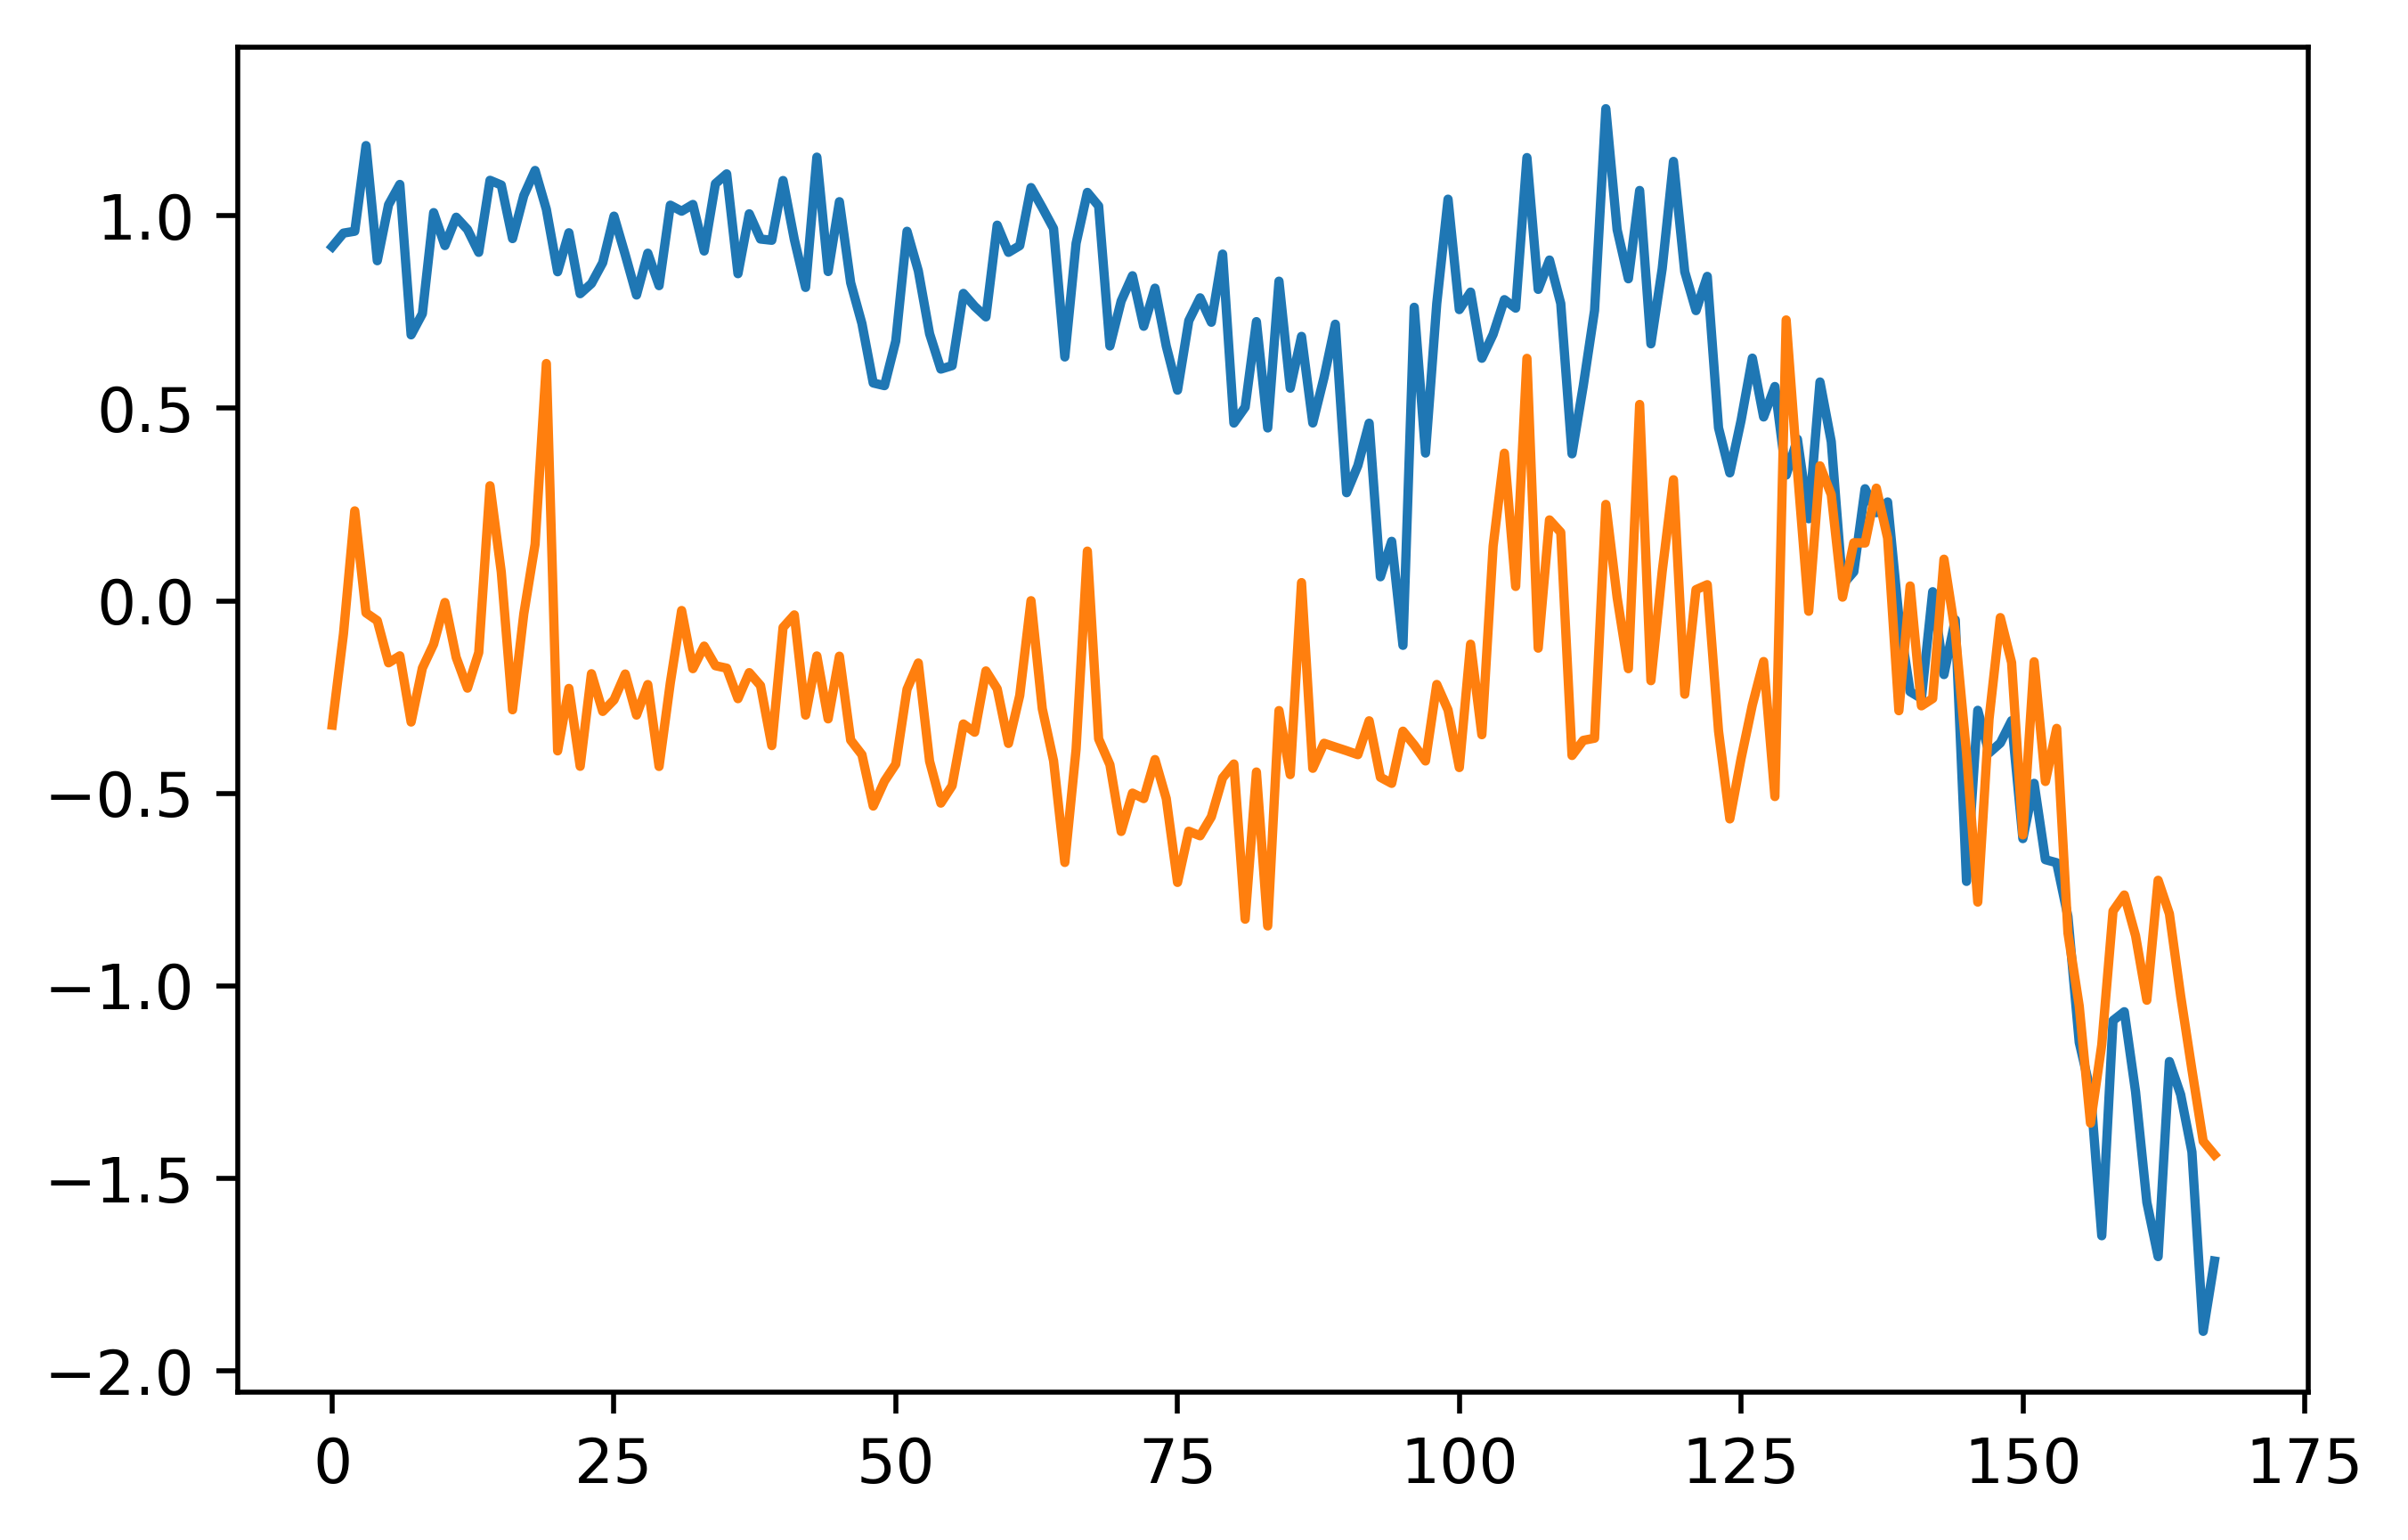

In [22]:
plt.plot(walsh_sie_anom)
plt.plot(walsh_sie_anom3)

In [23]:
# Find indices to take anomalies over: 
anom_ind = np.where((np.array(recon_years)<anom_end)&(np.array(recon_years)>=anom_start))

In [24]:
sie_ens_allit_2d_ccsm4 = np.reshape(sie_ens_allit_ccsm4,(sie_ens_allit_ccsm4.shape[0],
                                    sie_ens_allit_ccsm4.shape[1]*sie_ens_allit_ccsm4.shape[2]))
sie_ens_anom_allit_ccsm4 = sie_ens_allit_2d_ccsm4 - np.nanmean(np.squeeze(sie_ens_allit_2d_ccsm4[anom_ind,:]),axis=0)
sie_ensmn_anom_allit_ccsm4 = np.nanmean(sie_ens_anom_allit_ccsm4,axis=1)
sie_ensmn_allit_ccsm4_full = np.nanmean(sie_ens_allit_2d_ccsm4,axis=1)

sie_97_5_allit_ccsm4 = np.percentile(sie_ens_anom_allit_ccsm4,97.5,axis=1)
sie_2_5_allit_ccsm4 = np.percentile(sie_ens_anom_allit_ccsm4,2.5,axis=1)

sie_97_5_allit_ccsm4_full = np.percentile(sie_ens_allit_2d_ccsm4,97.5,axis=1)
sie_2_5_allit_ccsm4_full = np.percentile(sie_ens_allit_2d_ccsm4,2.5,axis=1)

[ce_sie_ccsm4,corr_sie_ccsm4,
 var_sie_sat_ccsm4,var_sie_recon_ccsm4] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                                       sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
                                                       bren2020_time,
                                                       np.array(recon_years),1850,1999)

In [26]:
sie_ens_allit_2d_mpi = np.reshape(sie_ens_allit_mpi,(sie_ens_allit_mpi.shape[0],
                                  sie_ens_allit_mpi.shape[1]*sie_ens_allit_mpi.shape[2]))
sie_ens_anom_allit_mpi = sie_ens_allit_2d_mpi - np.nanmean(np.squeeze(sie_ens_allit_2d_mpi[anom_ind,:]),axis=0)
sie_ensmn_anom_allit_mpi = np.nanmean(sie_ens_anom_allit_mpi,axis=1)

sie_97_5_allit_mpi = np.percentile(sie_ens_anom_allit_mpi,97.5,axis=1)
sie_2_5_allit_mpi = np.percentile(sie_ens_anom_allit_mpi,2.5,axis=1)

[ce_sie_mpi,corr_sie_mpi,
 var_sie_sat_mpi,var_sie_recon_mpi] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                                   sie_bren2020['sie_MPI_HadCRUT4_anom'],
                                                   bren2020_time,
                                                   np.array(recon_years),1850,1999)

In [59]:
sia_ens_allit_2d_mpi = np.reshape(sia_ens_allit_mpi,(sia_ens_allit_mpi.shape[0],
                                  sia_ens_allit_mpi.shape[1]*sia_ens_allit_mpi.shape[2]))
sia_ens_anom_allit_mpi = sia_ens_allit_2d_mpi - np.nanmean(np.squeeze(sia_ens_allit_2d_mpi[anom_ind,:]),axis=0)
sia_ensmn_anom_allit_mpi = np.nanmean(sia_ens_anom_allit_mpi,axis=1)
sia_anom_allit_mpi = np.reshape(sia_ens_anom_allit_mpi,(2000,200,10))

sia_97_5_allit_mpi = np.percentile(sia_ens_anom_allit_mpi,97.5,axis=1)
sia_2_5_allit_mpi = np.percentile(sia_ens_anom_allit_mpi,2.5,axis=1)

In [50]:
sie_ens_anom_allit_mpi.shape, sie_ens_allit_mpi.shape, sie_ens_anom_allit_mpi.shape

sie_anom_allit_mpi = np.reshape(sie_ens_anom_allit_mpi,(2000,200,10))

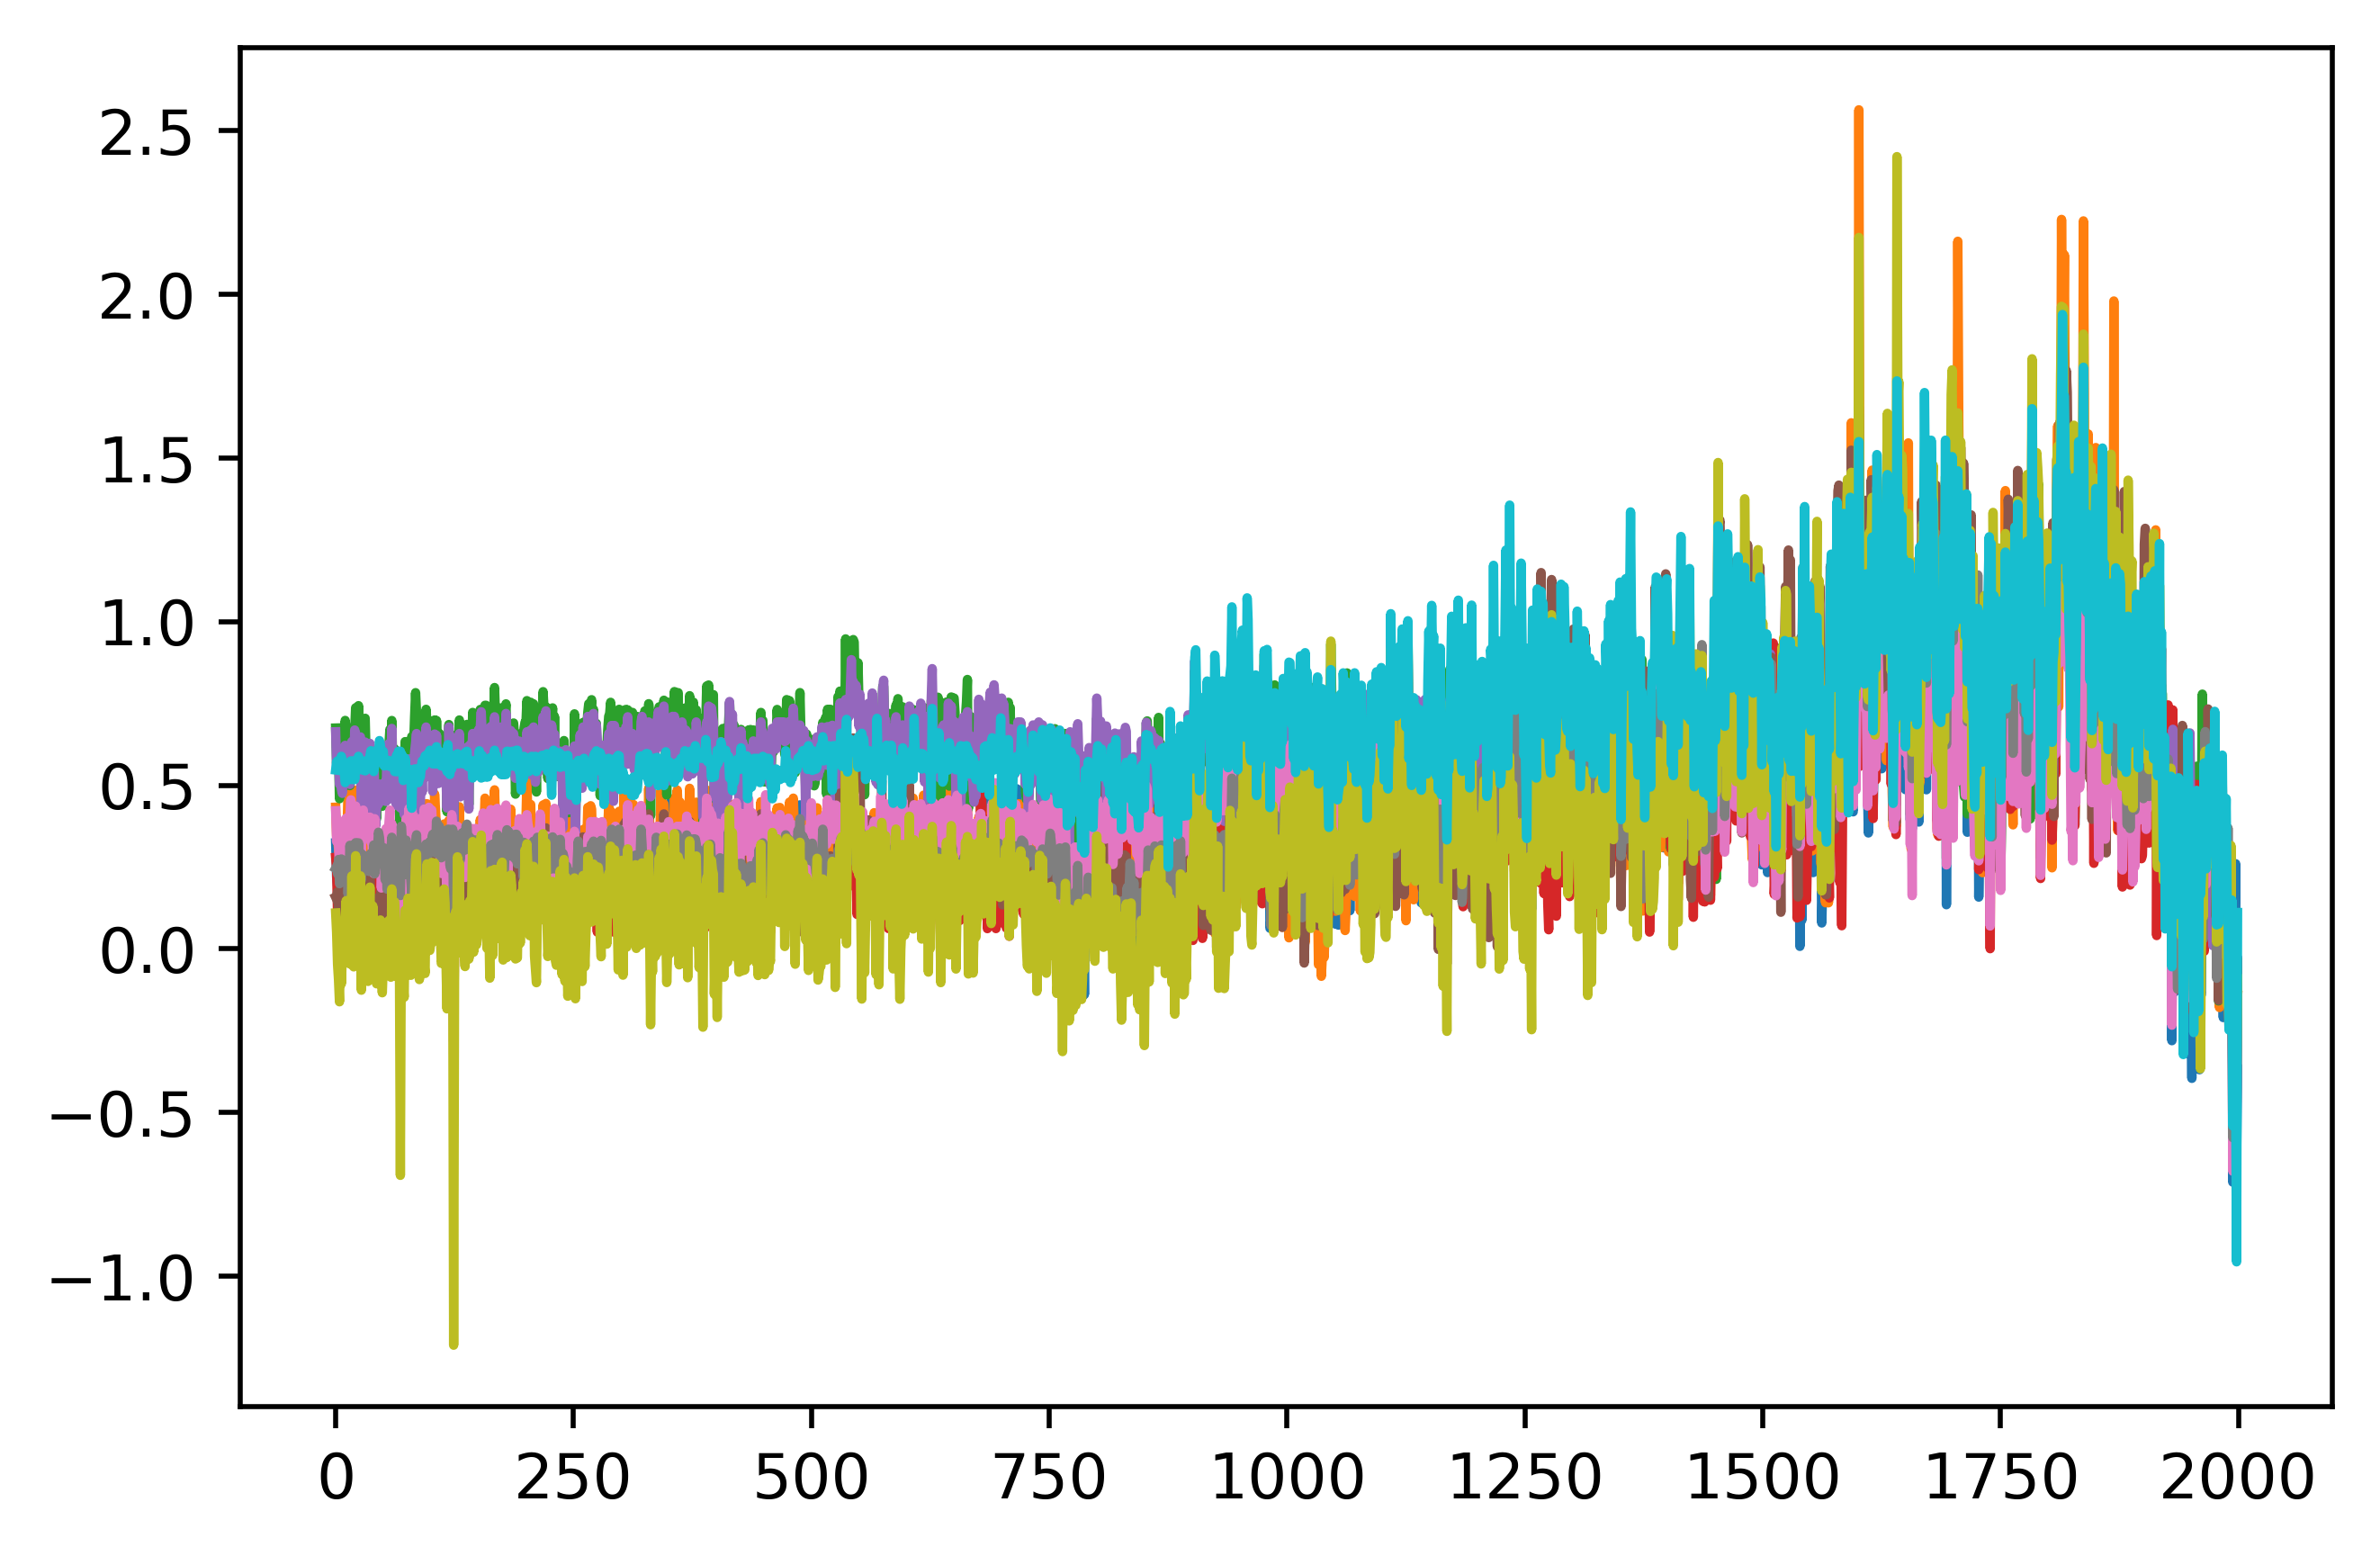

In [51]:
plt.plot(sie_anom_allit_mpi[:,0,:])

## Table 1:

In [28]:
[ce_sie_ccsm4_mpi,corr_sie_ccsm4_mpi,
 var_sie_sat_ccsm4_mpi,
 var_sie_recon_ccsm4_mpi] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                         sie_bren2020['sie_MPI_HadCRUT4_anom'],
                                         bren2020_time,
                                         np.array(recon_years),1850,1999)

[ce_sie_mpi_mpi,corr_sie_mpi_mpi,
 var_sie_sat_mpi_mpi,
 var_sie_recon_mpi_mpi] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                       sie_bren2020['sie_MPI_HadCRUT4_anom'],
                                       bren2020_time,
                                       np.array(recon_years),1850,1999)

[ce_sie_ccsm4_ccsm4,corr_sie_ccsm4_ccsm4,
 var_sie_sat_ccsm4_ccsm4,
 var_sie_recon_ccsm4_ccsm4] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                           sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
                                           bren2020_time,
                                           np.array(recon_years),1850,1999)

[ce_sie_mpi_ccsm4,corr_sie_mpi_ccsm4,
 var_sie_sat_mpi_ccsm4,
 var_sie_recon_mpi_ccsm4] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                         sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
                                         bren2020_time,
                                         np.array(recon_years),1850,1999)

[ce_sie_recon_mpi_ccsm4,
 corr_sie_recon_mpi_ccsm4,_,_] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                              sie_ensmn_anom_allit_mpi,
                                              np.array(recon_years),
                                              np.array(recon_years),1850,1999)

In [29]:
[ce_sie_walsh_mpi,corr_sie_walsh_mpi,
 var_sie_sat_walsh_mpi,
 var_sie_recon_walsh_mpi] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                          walsh_sie_anom,
                                          walsh_time,
                                          np.array(recon_years),1850,1999)

[ce_sie_walsh_ccsm4,corr_sie_walsh_ccsm4,
 var_sie_sat_walsh_ccsm4,
 var_sie_recon_walsh_ccsm4] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                           walsh_sie_anom,
                                           walsh_time,
                                           np.array(recon_years),1850,1999)

In [30]:
[ce_sie_walsh_mpi3,corr_sie_walsh_mpi3,
 var_sie_sat_walsh_mpi3,
 var_sie_recon_walsh_mpi3] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                          walsh_sie_anom3,
                                          walsh_time3,
                                          np.array(recon_years),1850,1999)

[ce_sie_walsh_ccsm43,corr_sie_walsh_ccsm43,
 var_sie_sat_walsh_ccsm43,
 var_sie_recon_walsh_ccsm43] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                           walsh_sie_anom3,
                                           walsh_time3,
                                           np.array(recon_years),1850,1999)

In [31]:
[ce_sie_ccsm4_sat,corr_sie_ccsm4_sat,
 var_sie_sat_ccsm4_sat,
 var_sie_recon_ccsm4_sat] = find_ce_corr(sie_ensmn_anom_allit_ccsm4, 
                                         fet_sie_anom,fet_time,
                                         np.array(recon_years),anom_start,anom_end-1)

[ce_sie_mpi_sat,corr_sie_mpi_sat,
 var_sie_sat_ccsm4_sat,
 var_sie_recon_ccsm4_sat] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                         fet_sie_anom,fet_time,
                                         np.array(recon_years),anom_start,anom_end-1)

In [32]:
# Revision 1 reconstructions: 

print("R^2: B20 CCSM4 v CCSM4 = "+ str(np.round(corr_sie_ccsm4_ccsm4**2,2)))
print("R^2: B20 CCSM4 v MPI   = "+ str(np.round(corr_sie_mpi_ccsm4**2,2))+'\n')

print("CE:  B20 CCSM4 v CCSM4 = "+ str(np.round(ce_sie_ccsm4_ccsm4,2)))
print("CE:  B20 CCSM4 v MPI   = "+ str(np.round(ce_sie_mpi_ccsm4,2))+'\n')

print("R^2:   B20 MPI v CCSM4 = "+ str(np.round(corr_sie_ccsm4_mpi**2,2)))
print("R^2:   B20 MPI v MPI   = "+ str(np.round(corr_sie_mpi_mpi**2,2))+'\n')

print("CE:    B20 MPI v CCSM4 = "+ str(np.round(ce_sie_ccsm4_mpi,2)))
print("CE:    B20 MPI v MPI   = "+ str(np.round(ce_sie_mpi_mpi,2))+'\n')

print("R^2:   Walsh v CCSM4   = "+ str(np.round(corr_sie_walsh_ccsm4**2,2)))
print("R^2:   Walsh v MPI     = "+ str(np.round(corr_sie_walsh_mpi**2,2))+'\n')

print("CE:    Walsh v CCSM4   = "+ str(np.round(ce_sie_walsh_ccsm4,2)))
print("CE:    Walsh v MPI     = "+ str(np.round(ce_sie_walsh_mpi,3))+'\n')

print("R^2:   Walsh3 v CCSM4   = "+ str(np.round(corr_sie_walsh_ccsm43**2,2)))
print("R^2:   Walsh3 v MPI     = "+ str(np.round(corr_sie_walsh_mpi3**2,2))+'\n')

print("CE:    Walsh3 v CCSM4   = "+ str(np.round(ce_sie_walsh_ccsm43,2)))
print("CE:    Walsh3 v MPI     = "+ str(np.round(ce_sie_walsh_mpi3,3))+'\n')

print("R^2:   sat v CCSM4     = "+ str(np.round(corr_sie_ccsm4_sat**2,2)))
print("R^2:   sat v MPI       = "+ str(np.round(corr_sie_mpi_sat**2,2))+'\n')

print("CE:    sat v CCSM4     = "+ str(np.round(ce_sie_ccsm4_sat,2)))
print("CE:    sat v MPI       = "+ str(np.round(ce_sie_mpi_sat,2))+'\n')

print("R^2:   Recon MPI v CCSM4 = "+ str(np.round(corr_sie_recon_mpi_ccsm4**2,2)))
print("CE:    Recon MPI v CCSM4 = "+ str(np.round(ce_sie_recon_mpi_ccsm4,2)))

R^2: B20 CCSM4 v CCSM4 = 0.5
R^2: B20 CCSM4 v MPI   = 0.46

CE:  B20 CCSM4 v CCSM4 = 0.31
CE:  B20 CCSM4 v MPI   = 0.02

R^2:   B20 MPI v CCSM4 = 0.59
R^2:   B20 MPI v MPI   = 0.56

CE:    B20 MPI v CCSM4 = 0.49
CE:    B20 MPI v MPI   = 0.27

R^2:   Walsh v CCSM4   = 0.37
R^2:   Walsh v MPI     = 0.49

CE:    Walsh v CCSM4   = -0.27
CE:    Walsh v MPI     = 0.126

R^2:   Walsh3 v CCSM4   = 0.01
R^2:   Walsh3 v MPI     = 0.0

CE:    Walsh3 v CCSM4   = -6.57
CE:    Walsh3 v MPI     = -7.899

R^2:   sat v CCSM4     = 0.6
R^2:   sat v MPI       = 0.5

CE:    sat v CCSM4     = 0.58
CE:    sat v MPI       = 0.45

R^2:   Recon MPI v CCSM4 = 0.85
CE:    Recon MPI v CCSM4 = 0.81


In [54]:
sic_lalo_mpi_ensmn = np.nanmean(sic_lalo_allit_mpi,axis=3)

## Make netcdf file: 

In [60]:
from datetime import datetime
import xarray as xr

datavars = {'si_extent_anomalies':(['time','nens','nit',],
                                   sie_anom_allit_mpi,
                                  {'units':'10^6 km^2',
                                   'long_name':('reconstructed total Arctic sea ice extent anomalies for all '+
                                                'iteration and ensemble members'),
                                   'anomalies_period':'anomalies relative to 1979-2000'}),
            'si_extent_ensemble_mean_anomalies':(['time'],
                                                 sie_ensmn_anom_allit_mpi,
                                                 {'units':'10^6 km^2',
                                                  'long_name':('reconstructed total Arctic sea ice extent '+
                                                               'anomalies'),
                                                  'anomalies_period':'anomalies relative to 1979-2000'}),
            'si_extent_97_5_percentiles':(['time'],
                                        sie_97_5_allit_mpi,
                                        {'units':'10^6 km^2',
                                        'long_name':('97.5th percentile across all 2000 ensemble members of '+
                                                     'reconstructed total Arctic sea ice extent anomalies')}),
            'si_extent_2_5_percentiles':(['time'],
                                        sie_2_5_allit_mpi,
                                        {'units':'10^6 km^2',
                                        'long_name':('2.5th percentile across all 2000 ensemble members of '+
                                                     'reconstructed total Arctic sea ice extent anomalies')}),
            'si_area_anomalies':(['time','nens','nit',],
                                   sia_anom_allit_mpi,
                                  {'units':'10^6 km^2',
                                   'long_name':('reconstructed total Arctic sea ice area anomalies for all '+
                                                'iteration and ensemble members'),
                                   'anomalies_period':'anomalies relative to 1979-2000'}),
            'si_area_ensemble_mean_anomalies':(['time'],
                                                 sia_ensmn_anom_allit_mpi,
                                                 {'units':'10^6 km^2',
                                                  'long_name':'reconstructed total Arctic sea ice area anomalies',
                                                  'anomalies_period':'anomalies relative to 1979-2000'}),
            'si_area_97_5_percentiles':(['time'],
                                        sia_97_5_allit_mpi,
                                        {'units':'10^6 km^2',
                                        'long_name':('97.5th percentile across all 2000 ensemble members of '+
                                                     'reconstructed total Arctic sea ice area anomalies')}),
            'si_area_2_5_percentiles':(['time'],
                                        sia_2_5_allit_mpi,
                                        {'units':'10^6 km^2',
                                        'long_name':('2.5th percentile across all 2000 ensemble members of '+
                                                     'reconstructed total Arctic sea ice area anomalies')}),
             'sic_lalo_ensemble_mean':(['time','lat','lon'],
                                       sic_lalo_mpi_ensmn,
                                       {'units':'percent(%)','long_name':'Sea ice concentration'})}

coords = {'time':(['time'],np.array(recon_years),{'units':'year (CE)'}),
          'lat':(['lat'], ccsm4_truth_lat[:,0],{'units':'degrees north'}),
          'lot':(['lot'], ccsm4_truth_lon[0,:],{'units':'degrees east'}),
          'nit':(['nit'], np.arange(0,10,1),{'long_name':'ensemble member'}),
          'nens':(['nens'], np.arange(0,200,1),{'long_name':'Monte Carlo iteration'})}

attrs = {'creation_date':'2021-11-16', 
         'author':'M. Kathleen Brennan', 
         'email':'mkb22@uw.edu',
         'experiment': ('Results from assimilating temperature-sensitive proxie from '+
                        'Pages2kv2 dataset (Emile-Geay et al. 2017) and '+
                        'prior ensembles drawn from MPI Last Millennium simulations.')}

ds = xr.Dataset(data_vars=datavars,
               coords=coords,
               attrs=attrs)

savedir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
savename = 'Brennan_etal_2021_MPI_model_prior_reconstructions_all.nc'

ds.to_netcdf(savedir+savename)

In [50]:
datavars = {'si_extent_recon_anomalies':(['time'],
                                         sie_ensmn_anom_allit_ccsm4,
                                         {'units':'10^6 km^2',
                                          'long_name':'reconstructed total Arctic sea ice extent anomalies',
                                          'anomalies_period':'anomalies relative to 1979-2000'}),
            'si_extent_recon_97_5_percentiles':(['time'],
                                                sie_97_5_allit_ccsm4,
                                                {'units':'10^6 km^2',
                                                'long_name':'97.5th percentile across all 2000 ensemble members of reconstructed total Arctic sea ice extent anomalies'}),
            'si_extent_recon_2_5_percentiles':(['time'],
                                                sie_2_5_allit_ccsm4,
                                                {'units':'10^6 km^2',
                                                'long_name':'2.5th percentile across all 2000 ensemble members of reconstructed total Arctic sea ice extent anomalies'}),
             'sic_lalo_ensmn':(['time','lat','lon'],
                               sic_lalo_ccsm4_ensmn,{'units':'percent(%)',
                                                   'long_name':'Sea ice concentration'})}

coords = {'time':(['time'],np.array(recon_years),{'units':'year (CE)'}),
          'lat':(['lat'], ccsm4_truth_lat[:,0],{'units':'degrees north'}),
          'lot':(['lot'],ccsm4_truth_lon[0,:],{'units':'degrees east'})}

attrs = {'creation_date':'2021-11-16', 
         'author':'M. Kathleen Brennan', 
         'email':'mkb22@uw.edu',
         'experiment': ('Results from assimilating temperature-sensitive proxie from '+
                        'Pages2kv2 dataset (Emile-Geay et al. 2017) and '+
                        'prior ensembles drawn from CCSM4 Last Millennium simulations.')}

ds = xr.Dataset(data_vars=datavars,
               coords=coords,
               attrs=attrs)

savedir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
savename = 'Brennan_etal_2021_CCSM4_model_prior_reconstructions.nc'

ds.to_netcdf(savedir+savename)

## Figure 3:

In [36]:
sie_ens_allit_2d_mpi = np.reshape(sie_ens_allit_mpi,(sie_ens_allit_mpi.shape[0],
                                  sie_ens_allit_mpi.shape[1]*sie_ens_allit_mpi.shape[2]))
sie_ens_anom_allit_mpi = sie_ens_allit_2d_mpi - np.nanmean(np.squeeze(sie_ens_allit_2d_mpi[anom_ind,:]),axis=0)
sie_ensmn_anom_allit_mpi = np.nanmean(sie_ens_anom_allit_mpi,axis=1)

sie_97_5_allit_mpi = np.percentile(sie_ens_anom_allit_mpi,97.5,axis=1)
sie_2_5_allit_mpi = np.percentile(sie_ens_anom_allit_mpi,2.5,axis=1)

[ce_sie_mpi,corr_sie_mpi,
 var_sie_sat_mpi,var_sie_recon_mpi] = find_ce_corr(sie_ensmn_anom_allit_mpi, 
                                                   sie_bren2020['sie_MPI_HadCRUT4_anom'],
                                                   bren2020_time,
                                                   np.array(recon_years),1850,1999)

In [37]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

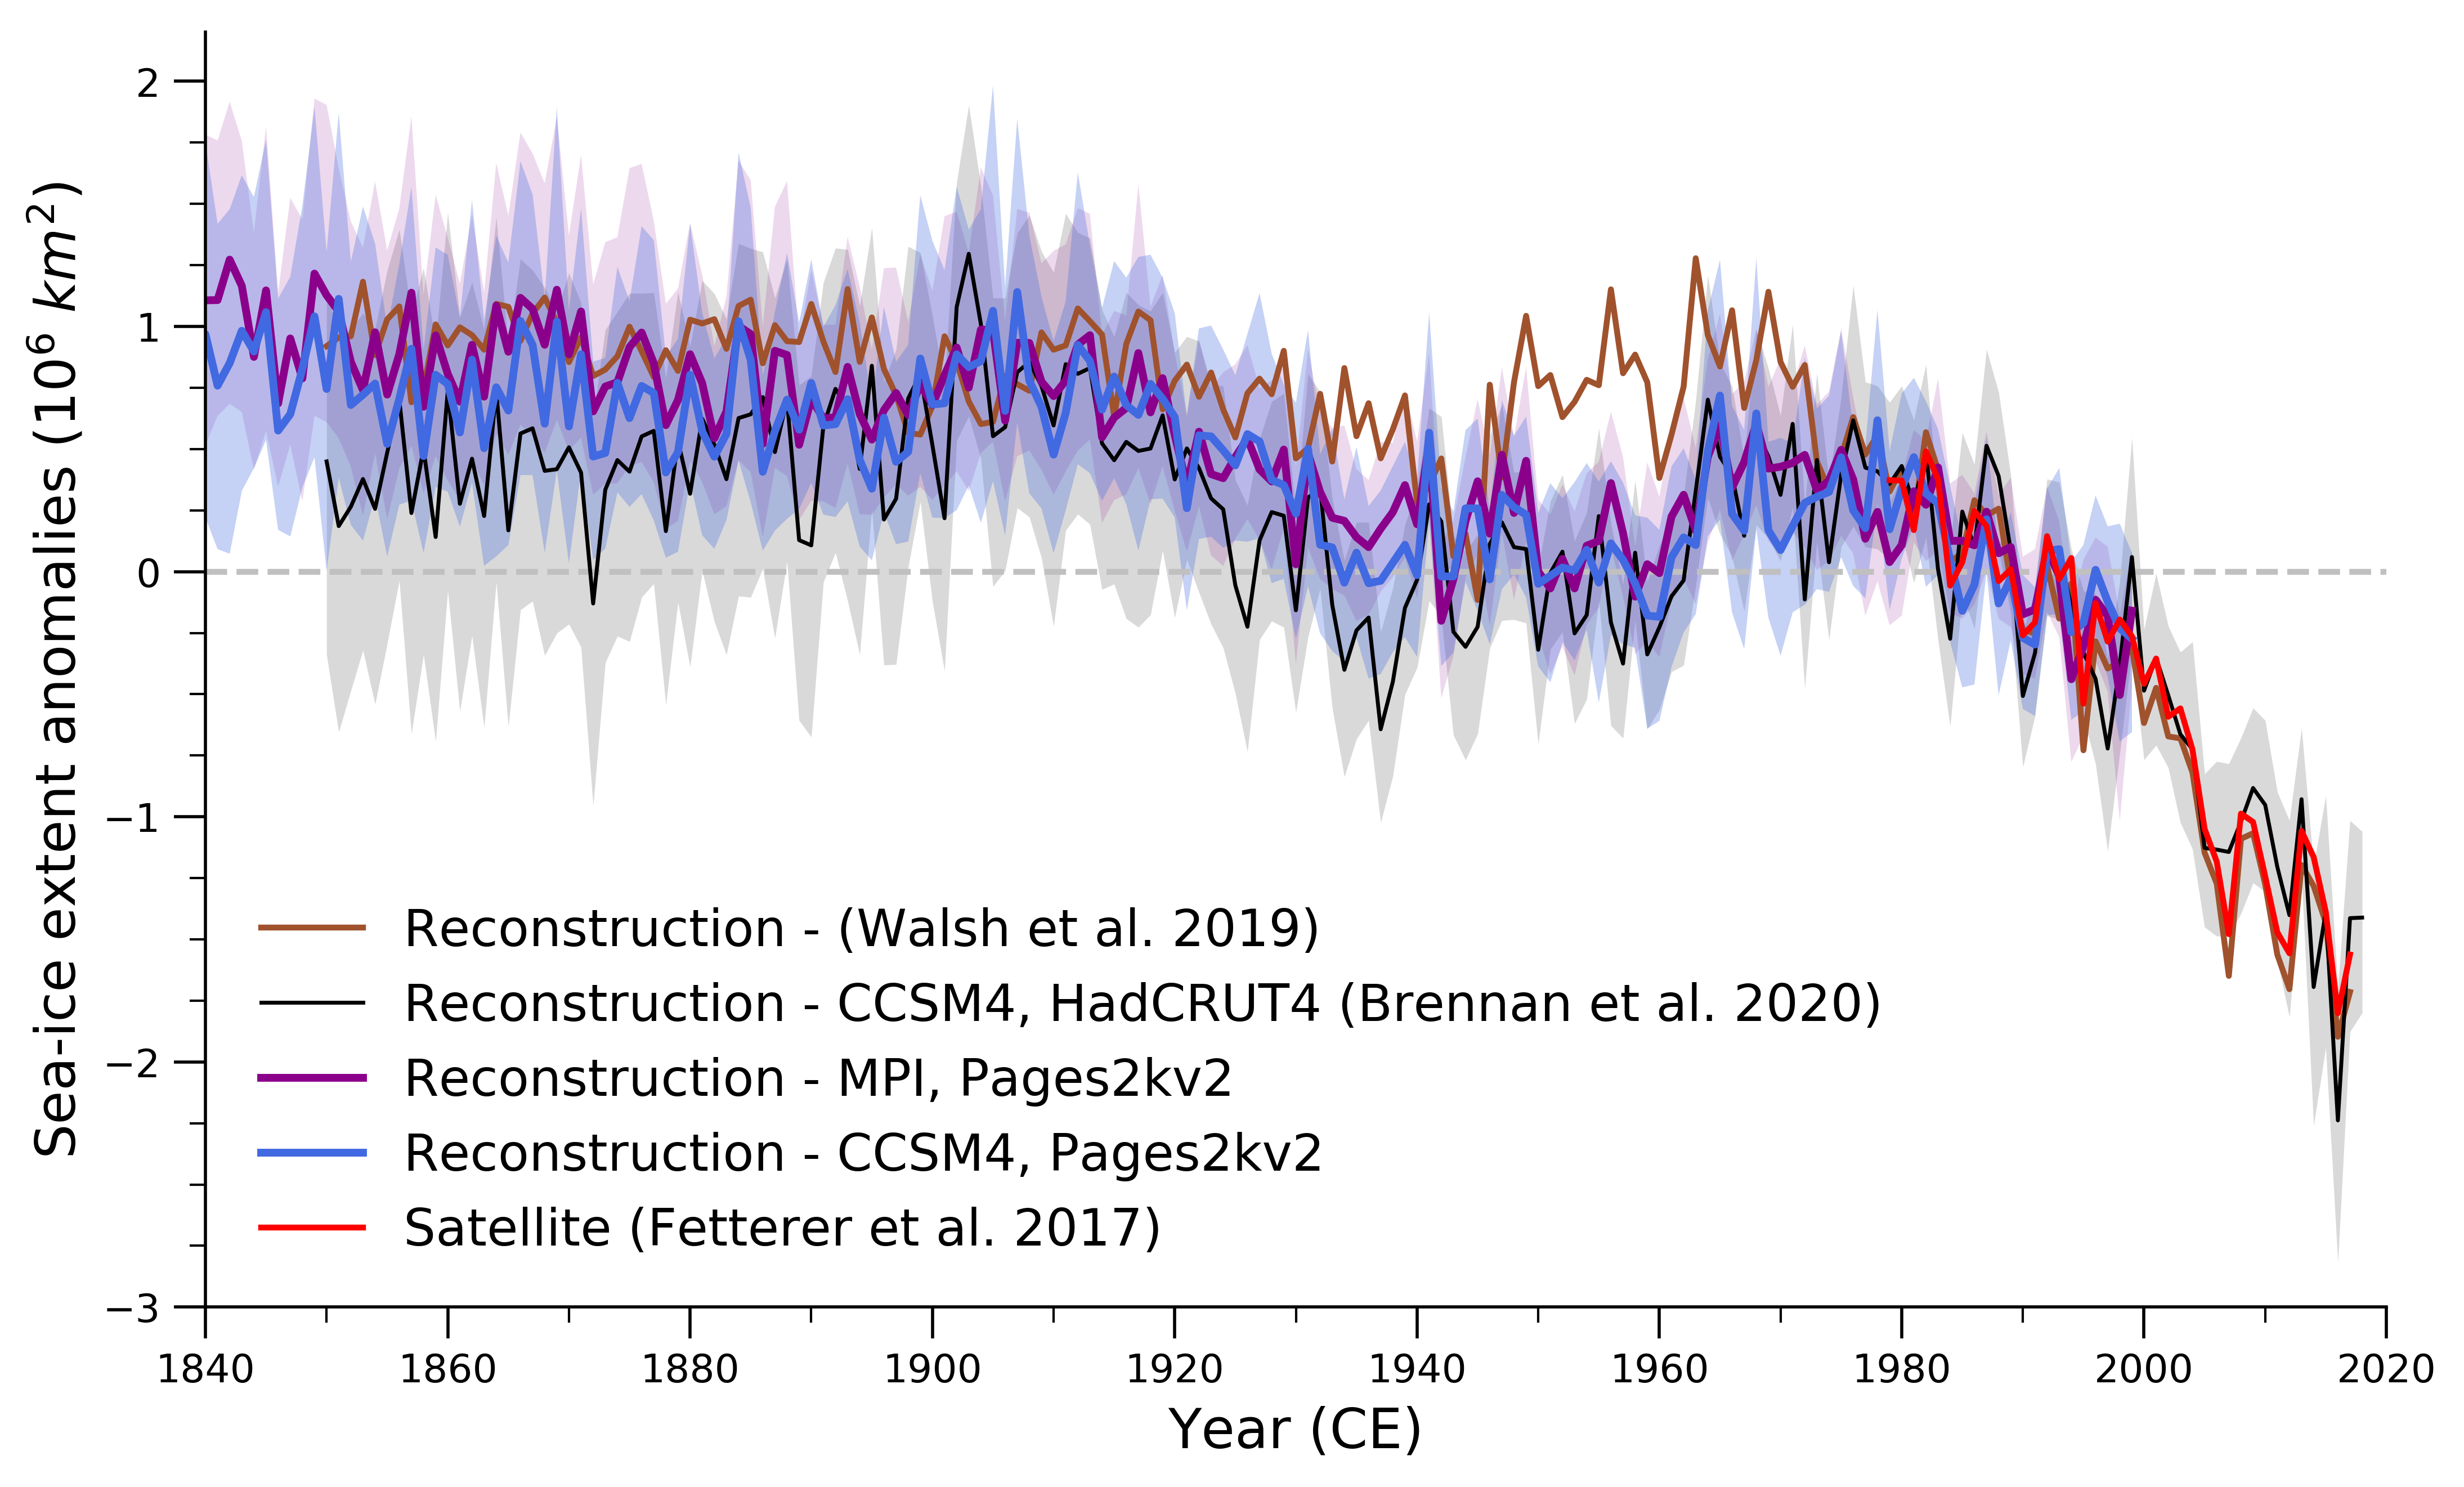

In [38]:
#plt.figure(figsize=(10,6))
fig,ax = plt.subplots(1,figsize=(10,6))
plt.axhline(0,linestyle='--',color='silver')

# plt.fill_between(recon_years,sie_2_5_allit_mpi,sie_97_5_allit_mpi,alpha=0.15, color='purple')
plt.fill_between(bren2020_time,sie_CCSM4_HadCRUT4_2_5_anom,sie_CCSM4_HadCRUT4_97_5_anom,
                 color='k',alpha=0.15,linewidth=0.01)
# plt.fill_between(bren2020_time,sie_MPI_HadCRUT4_2_5_anom,sie_MPI_HadCRUT4_97_5_anom,
#                  color='k',alpha=0.15,linewidth=0.01)
plt.fill_between(recon_years,sie_2_5_allit_mpi,sie_97_5_allit_mpi,
                 alpha=0.15, color='darkmagenta',linewidth=0.0)
plt.fill_between(recon_years,sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,
                 alpha=0.3, color='royalblue',linewidth=0.01)

plt.plot(walsh_time,walsh_sie_anom,
         label='Reconstruction - (Walsh et al. 2019)', color='sienna',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))
plt.plot(bren2020_time,sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
         label='Reconstruction - CCSM4, HadCRUT4 (Brennan et al. 2020)',
         color='k',linewidth=1)
# plt.plot(bren2020_time,sie_bren2020['sie_MPI_HadCRUT4_anom'],
#          label='Reconstruction - MPI, HadCRUT4 (Brennan et al. 2020)',
#          color='k',linewidth=1.5)
plt.plot(recon_years,sie_ensmn_anom_allit_mpi,color='darkmagenta',#'#8756e4',
         label='Reconstruction - MPI, Pages2kv2',linewidth=2)
plt.plot(recon_years,sie_ensmn_anom_allit_ccsm4,color='royalblue',#'#8756e4',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=2)

# plt.plot(bren2020_time,sie_bren2020['sie_MPI_HadCRUT4_anom'],
#          label='MPI prior, HadCRUT4 obs (Brennan et al. 2020)', color='grey',linewidth=1.5)
plt.plot(fet_time,fet_sie_anom,label='Satellite (Fetterer et al. 2017)', color='r',linewidth=1.5)

plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,bbox_to_anchor=(0.79, 0.35),frameon=False)
#plt.ylim(7,13.1,1)
ce_corr_plt_ccsm4 = (('(Brennan et al. 2020, DA proxy recon): R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_ccsm4**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_ccsm4))
ce_corr_plt_sat = (('(Satellite, DA proxy recon):                   R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_sat**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_sat))

# plt.gcf().text(0.14, 0.14, ce_corr_plt_ccsm4 , fontsize=12,color='k')
# plt.gcf().text(0.14, 0.185, ce_corr_plt_sat , fontsize=12,color='k')

plt.xlim(1840,2020)
plt.ylim(-3,2.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# plt.axvline(1907,linestyle='--',color='silver')
# plt.axvline(1938,linestyle='--',color='silver')
# plt.axvline(1964,linestyle='--',color='silver')
# plt.axvline(1950,linestyle='--',color='silver')

#print(ce_sie,corr_sie,var_sie_sat,var_sie_recon)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sie_ccsm4_mpi_v_sat_walshv2_brennan_ccsm4_10it_1850_2017.png'
#plt.savefig(savedir+savename)

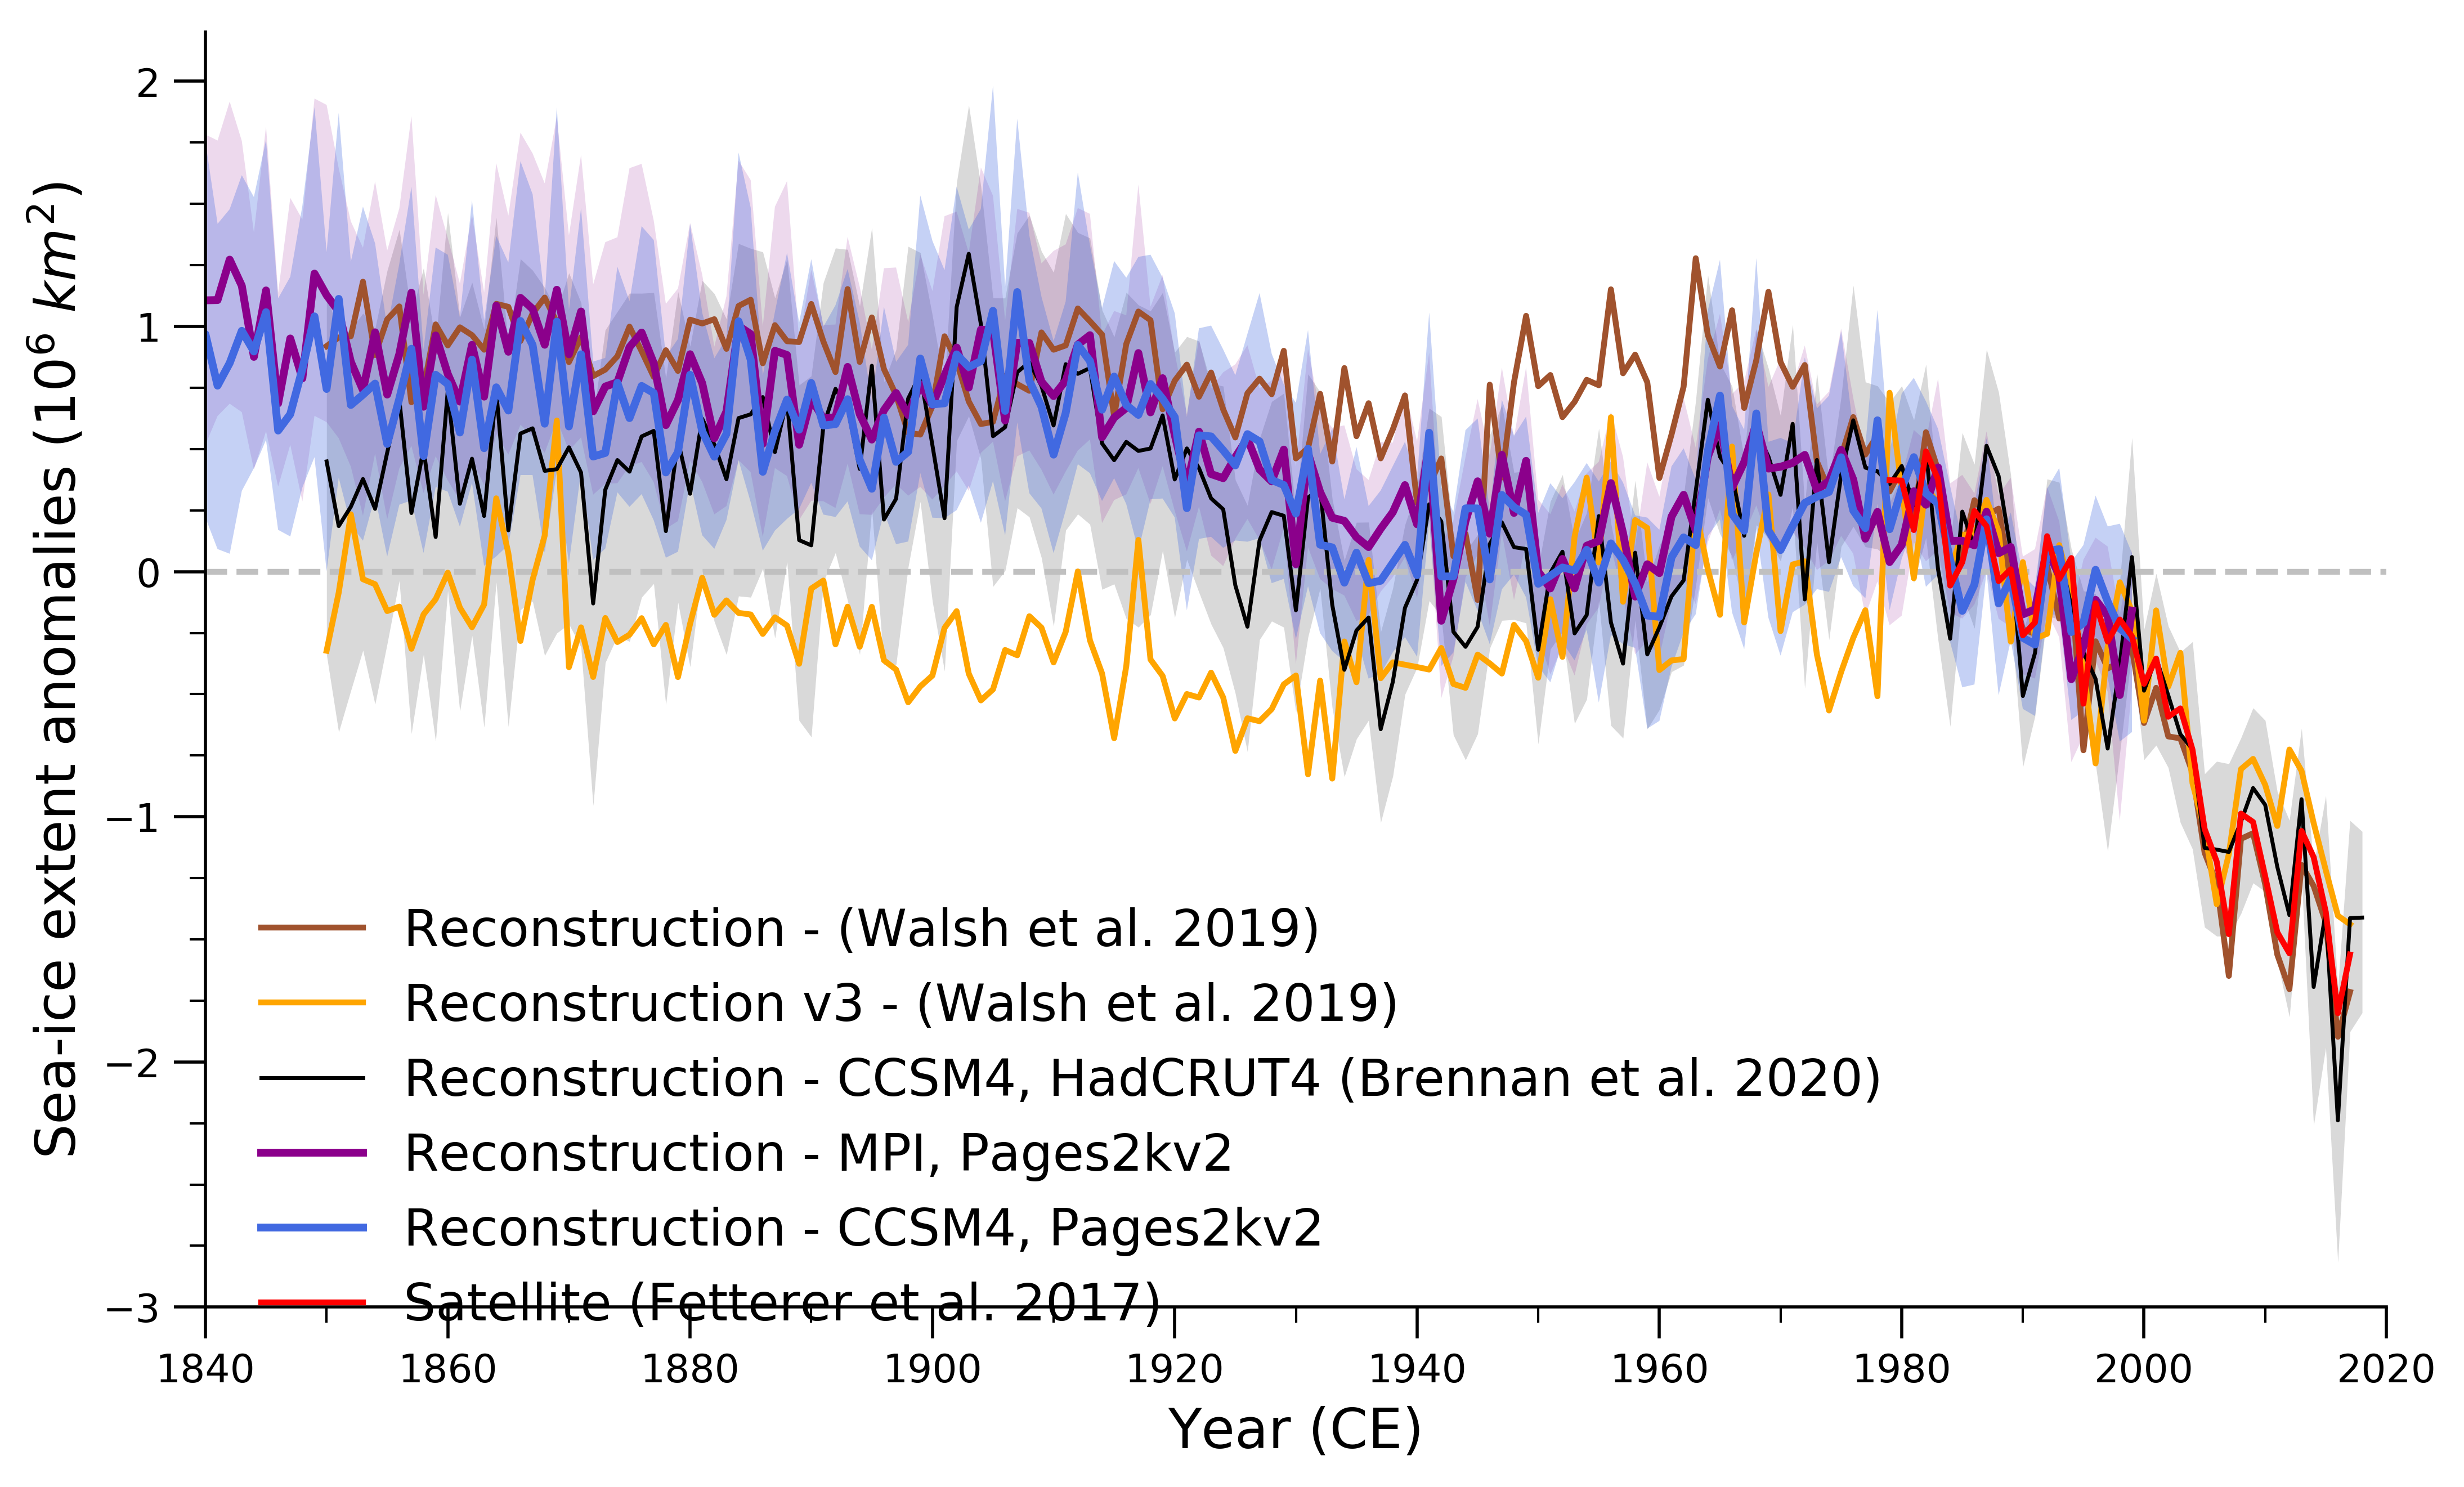

In [39]:
#plt.figure(figsize=(10,6))
fig,ax = plt.subplots(1,figsize=(10,6))
plt.axhline(0,linestyle='--',color='silver')

# plt.fill_between(recon_years,sie_2_5_allit_mpi,sie_97_5_allit_mpi,alpha=0.15, color='purple')
plt.fill_between(bren2020_time,sie_CCSM4_HadCRUT4_2_5_anom,sie_CCSM4_HadCRUT4_97_5_anom,
                 color='k',alpha=0.15,linewidth=0.01)
# plt.fill_between(bren2020_time,sie_MPI_HadCRUT4_2_5_anom,sie_MPI_HadCRUT4_97_5_anom,
#                  color='k',alpha=0.15,linewidth=0.01)
plt.fill_between(recon_years,sie_2_5_allit_mpi,sie_97_5_allit_mpi,
                 alpha=0.15, color='darkmagenta',linewidth=0.0)
plt.fill_between(recon_years,sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,
                 alpha=0.3, color='royalblue',linewidth=0.01)

plt.plot(walsh_time,walsh_sie_anom,
         label='Reconstruction - (Walsh et al. 2019)', color='sienna',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))
plt.plot(walsh_time3,walsh_sie_anom3,
         label='Reconstruction v3 - (Walsh et al. 2019)', color='orange',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))

plt.plot(bren2020_time,sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
         label='Reconstruction - CCSM4, HadCRUT4 (Brennan et al. 2020)',
         color='k',linewidth=1)
# plt.plot(bren2020_time,sie_bren2020['sie_MPI_HadCRUT4_anom'],
#          label='Reconstruction - MPI, HadCRUT4 (Brennan et al. 2020)',
#          color='k',linewidth=1.5)
plt.plot(recon_years,sie_ensmn_anom_allit_mpi,color='darkmagenta',#'#8756e4',
         label='Reconstruction - MPI, Pages2kv2',linewidth=2)
plt.plot(recon_years,sie_ensmn_anom_allit_ccsm4,color='royalblue',#'#8756e4',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=2)

# plt.plot(bren2020_time,sie_bren2020['sie_MPI_HadCRUT4_anom'],
#          label='MPI prior, HadCRUT4 obs (Brennan et al. 2020)', color='grey',linewidth=1.5)
plt.plot(fet_time,fet_sie_anom,label='Satellite (Fetterer et al. 2017)', color='r',linewidth=1.5)

plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,bbox_to_anchor=(0.79, 0.35),frameon=False)
#plt.ylim(7,13.1,1)
ce_corr_plt_ccsm4 = (('(Brennan et al. 2020, DA proxy recon): R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_ccsm4**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_ccsm4))
ce_corr_plt_sat = (('(Satellite, DA proxy recon):                   R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_sat**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_sat))

# plt.gcf().text(0.14, 0.14, ce_corr_plt_ccsm4 , fontsize=12,color='k')
# plt.gcf().text(0.14, 0.185, ce_corr_plt_sat , fontsize=12,color='k')

plt.xlim(1840,2020)
plt.ylim(-3,2.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# plt.axvline(1907,linestyle='--',color='silver')
# plt.axvline(1938,linestyle='--',color='silver')
# plt.axvline(1964,linestyle='--',color='silver')
# plt.axvline(1950,linestyle='--',color='silver')

#print(ce_sie,corr_sie,var_sie_sat,var_sie_recon)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sie_ccsm4_mpi_v_sat_walshv2_brennan_ccsm4_10it_1850_2017.png'
#plt.savefig(savedir+savename)

# SIA comparison: 

In [40]:
sia_ens_allit_2d_ccsm4 = np.reshape(sia_ens_allit_ccsm4,(sia_ens_allit_ccsm4.shape[0],
                                    sia_ens_allit_ccsm4.shape[1]*sia_ens_allit_ccsm4.shape[2]))
sia_ens_anom_allit_ccsm4 = sia_ens_allit_2d_ccsm4 - np.nanmean(np.squeeze(sia_ens_allit_2d_ccsm4[anom_ind,:]),axis=0)
sia_ensmn_anom_allit_ccsm4 = np.nanmean(sia_ens_anom_allit_ccsm4,axis=1)
sia_ensmn_allit_ccsm4_full = np.nanmean(sia_ens_allit_2d_ccsm4,axis=1)

sia_97_5_allit_ccsm4 = np.percentile(sia_ens_anom_allit_ccsm4,97.5,axis=1)
sia_2_5_allit_ccsm4 = np.percentile(sia_ens_anom_allit_ccsm4,2.5,axis=1)

sia_97_5_allit_ccsm4_full = np.percentile(sia_ens_allit_2d_ccsm4,97.5,axis=1)
sia_2_5_allit_ccsm4_full = np.percentile(sia_ens_allit_2d_ccsm4,2.5,axis=1)

# [ce_sia_ccsm4,corr_sia_ccsm4,
#  var_sia_sat_ccsm4,var_sia_recon_ccsm4] = rrutils.find_ce_corr(sia_ensmn_anom_allit_ccsm4, 
#                                                                sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
#                                                                bren2020_time,
#                                                                np.array(recon_years),1850,1999)

In [41]:
sia_ens_allit_2d_mpi = np.reshape(sia_ens_allit_mpi,(sia_ens_allit_mpi.shape[0],
                                  sia_ens_allit_mpi.shape[1]*sia_ens_allit_mpi.shape[2]))
sia_ens_anom_allit_mpi = sia_ens_allit_2d_mpi - np.nanmean(np.squeeze(sia_ens_allit_2d_mpi[anom_ind,:]),axis=0)
sia_ensmn_anom_allit_mpi = np.nanmean(sia_ens_anom_allit_mpi,axis=1)

sia_97_5_allit_mpi = np.percentile(sia_ens_anom_allit_mpi,97.5,axis=1)
sia_2_5_allit_mpi = np.percentile(sia_ens_anom_allit_mpi,2.5,axis=1)

# [ce_sie_mpi,corr_sie_mpi,
#  var_sie_sat_mpi,var_sie_recon_mpi] = rrutils.find_ce_corr(sie_ensmn_anom_allit_mpi, 
#                                                            sie_bren2020['sie_MPI_HadCRUT4_anom'],
#                                                            bren2020_time,
#                                                            np.array(recon_years),1850,1999)

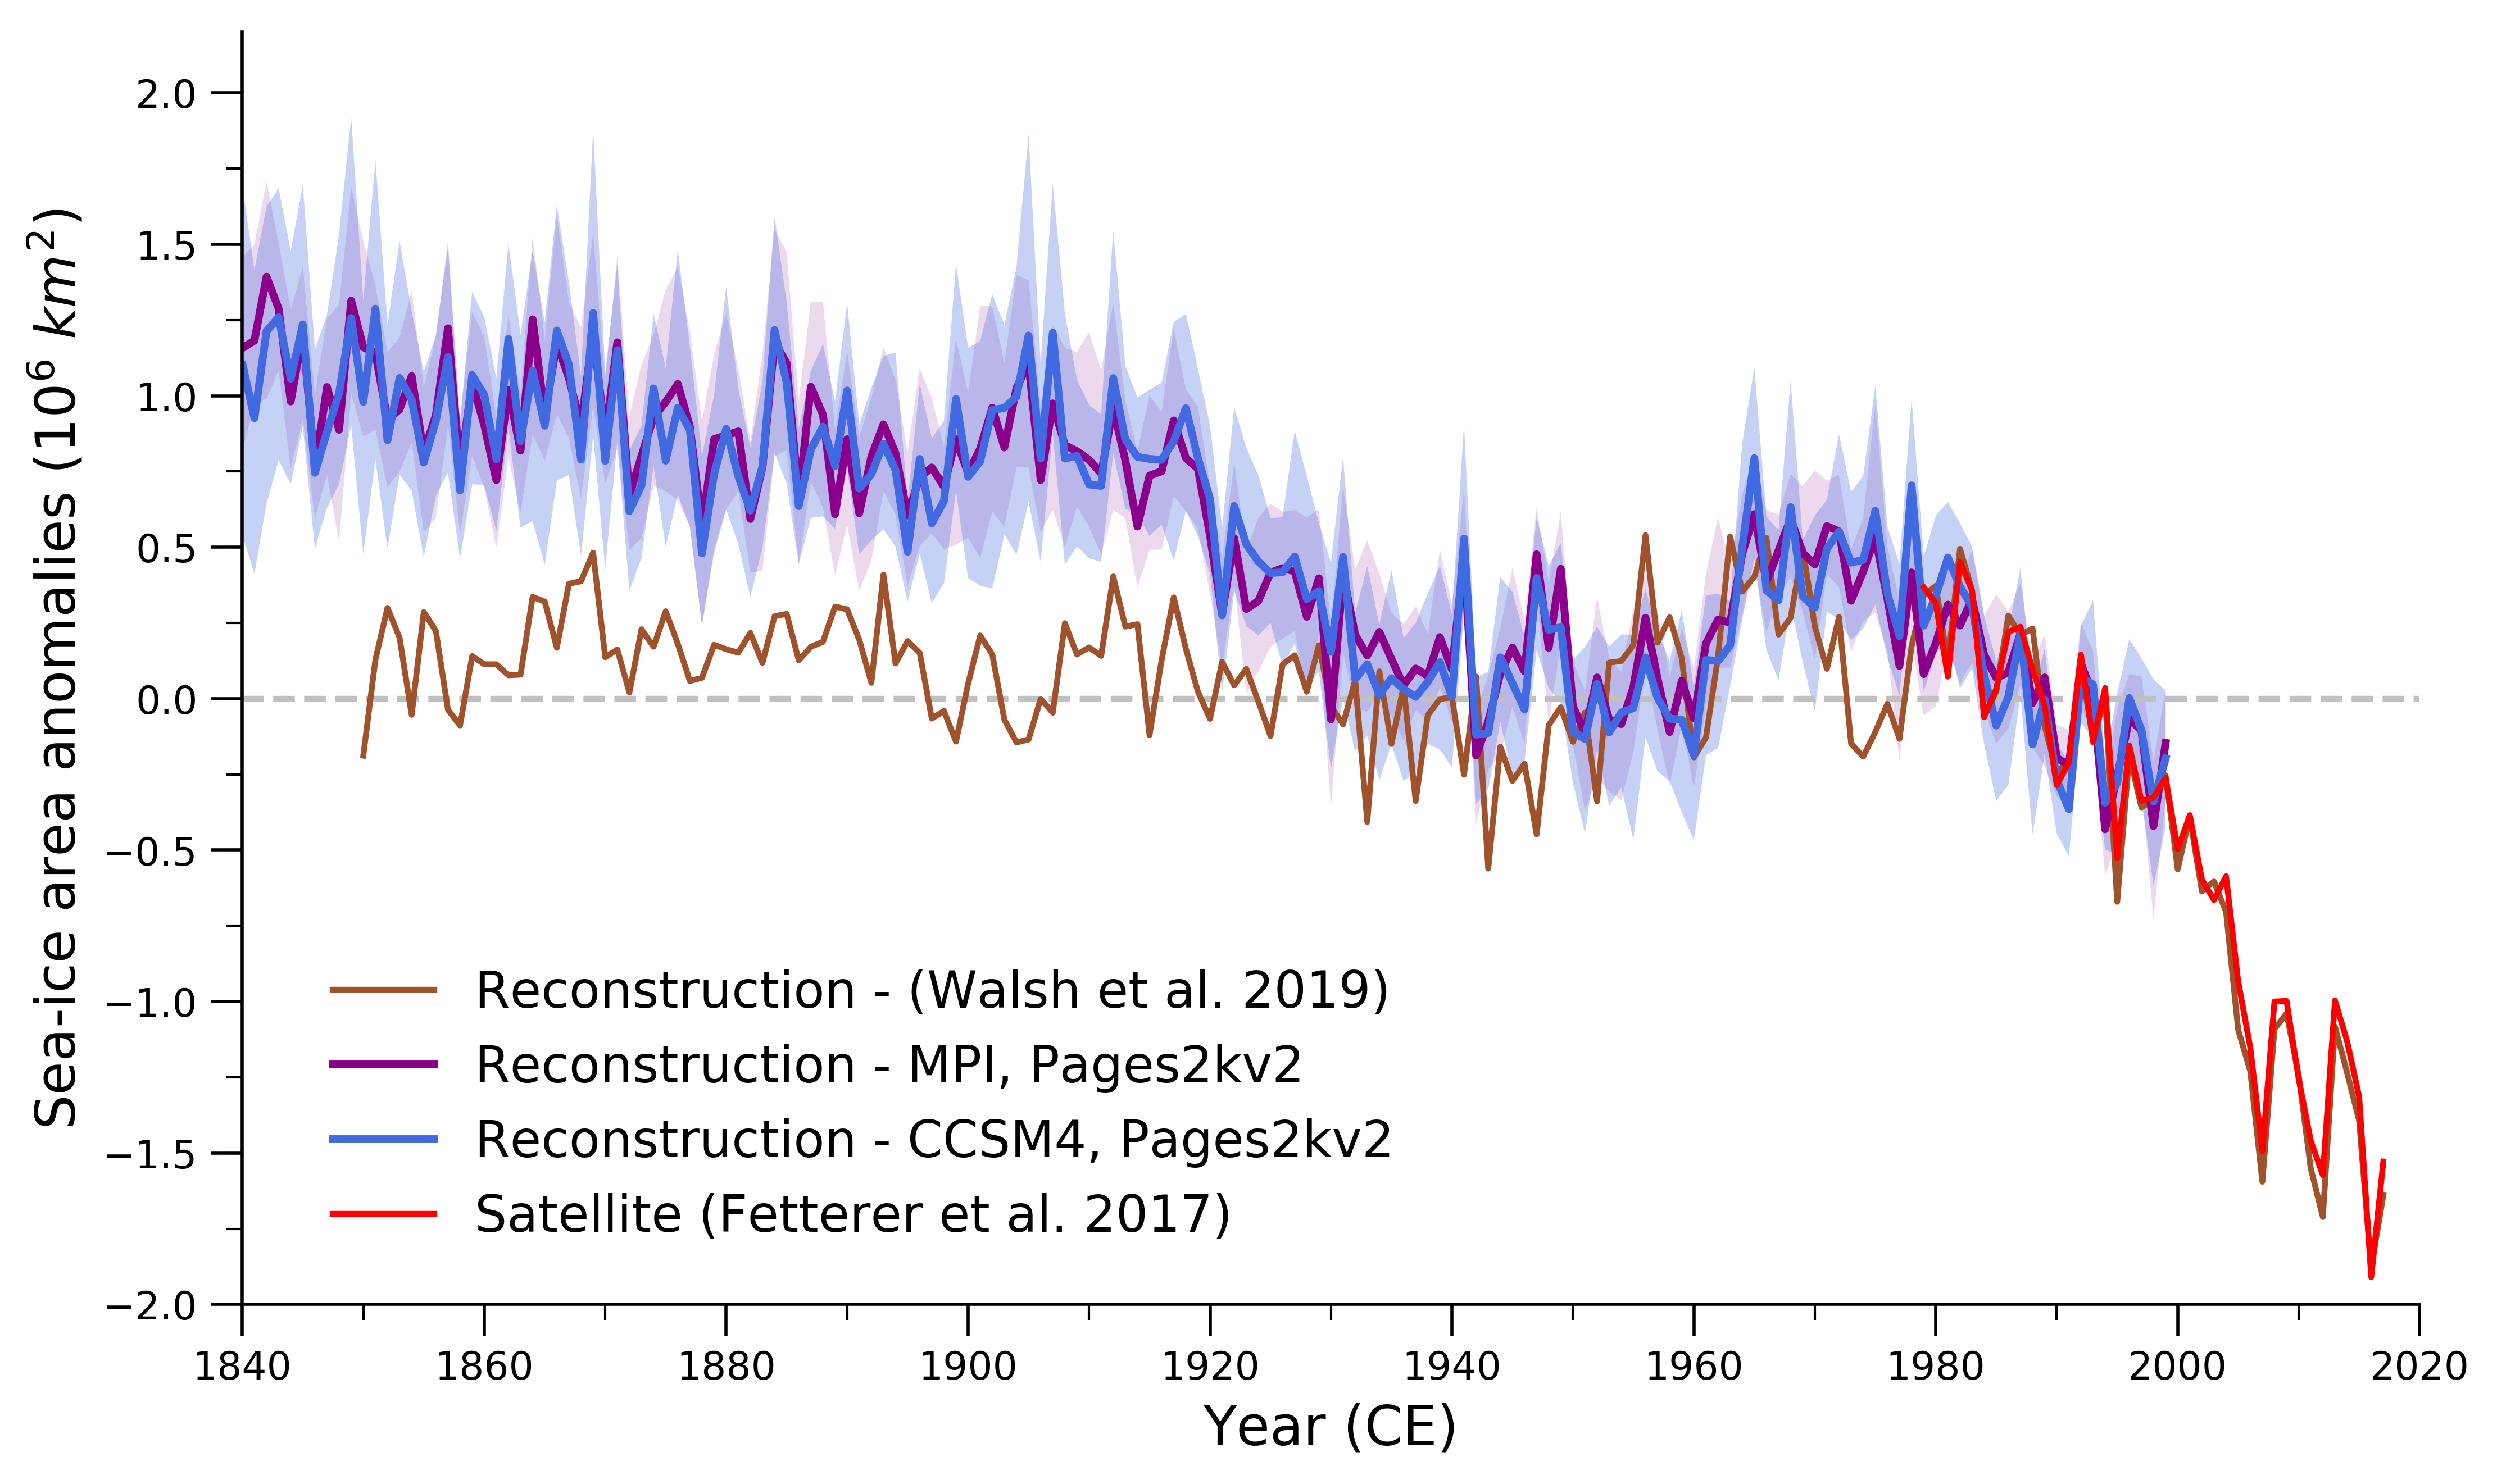

In [42]:
#plt.figure(figsize=(10,6))
fig,ax = plt.subplots(1,figsize=(10,6))
plt.axhline(0,linestyle='--',color='silver')

plt.fill_between(recon_years,sia_2_5_allit_mpi,sia_97_5_allit_mpi,
                 alpha=0.15, color='darkmagenta',linewidth=0.0)
plt.fill_between(recon_years,sia_2_5_allit_ccsm4,sia_97_5_allit_ccsm4,
                 alpha=0.3, color='royalblue',linewidth=0.01)

plt.plot(walsh_time,walsh_sia_anom,
         label='Reconstruction - (Walsh et al. 2019)', color='sienna',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))

plt.plot(recon_years,sia_ensmn_anom_allit_mpi,color='darkmagenta',#'#8756e4',
         label='Reconstruction - MPI, Pages2kv2',linewidth=2)
plt.plot(recon_years,sia_ensmn_anom_allit_ccsm4,color='royalblue',#'#8756e4',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=2)

plt.plot(fet_time,fet_sia_anom_adj,label='Satellite (Fetterer et al. 2017)', color='r',linewidth=1.5)

plt.ylabel('Sea-ice area anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,bbox_to_anchor=(0.55, 0.3),frameon=False)
#plt.ylim(7,13.1,1)
# ce_corr_plt_ccsm4 = (('(Brennan et al. 2020, DA proxy recon): R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_ccsm4**2))+
#                ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_ccsm4))
# ce_corr_plt_sat = (('(Satellite, DA proxy recon):                   R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_sat**2))+
#                ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_sat))

# plt.gcf().text(0.14, 0.14, ce_corr_plt_ccsm4 , fontsize=12,color='k')
# plt.gcf().text(0.14, 0.185, ce_corr_plt_sat , fontsize=12,color='k')

plt.xlim(1840,2020)
plt.ylim(-2.0,2.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# plt.axvline(1907,linestyle='--',color='silver')
# plt.axvline(1938,linestyle='--',color='silver')
# plt.axvline(1964,linestyle='--',color='silver')
# plt.axvline(1950,linestyle='--',color='silver')

#print(ce_sie,corr_sie,var_sie_sat,var_sie_recon)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sia_ccsm4_mpi_v_sat_walshv2_brennan_ccsm4_10it_1850_2017.png'
plt.savefig(savedir+savename)

In [43]:
[ce_sia_recon_mpi_ccsm4,
 corr_sia_recon_mpi_ccsm4,_,_] = find_ce_corr(sia_ensmn_anom_allit_ccsm4, 
                                                      sia_ensmn_anom_allit_mpi,
                                                      np.array(recon_years),
                                                      np.array(recon_years),1850,1999)

[ce_sia_walsh_mpi,corr_sia_walsh_mpi,
 var_sia_sat_walsh_mpi,
 var_sia_recon_walsh_mpi] = find_ce_corr(sia_ensmn_anom_allit_mpi, 
                                                  walsh_sia_anom,
                                                  walsh_time,
                                                  np.array(recon_years),1850,1999)

[ce_sia_walsh_ccsm4,corr_sia_walsh_ccsm4,
 var_sia_sat_walsh_ccsm4,
 var_sia_recon_walsh_ccsm4] = find_ce_corr(sia_ensmn_anom_allit_ccsm4, 
                                                   walsh_sia_anom,
                                                   walsh_time,
                                                   np.array(recon_years),1850,1999)

In [44]:
[ce_sia_ccsm4_sat,corr_sia_ccsm4_sat,
 var_sia_sat_ccsm4_sat,
 var_sia_recon_ccsm4_sat] = find_ce_corr(sia_ensmn_anom_allit_ccsm4, 
                                                 fet_sia_anom_adj,fet_time,
                                                 np.array(recon_years),anom_start,anom_end-1)

[ce_sia_mpi_sat,corr_sia_mpi_sat,
 var_sia_sat_ccsm4_sat,
 var_sia_recon_ccsm4_sat] = find_ce_corr(sia_ensmn_anom_allit_mpi, 
                                                 fet_sia_anom,fet_time,
                                                 np.array(recon_years),anom_start,anom_end-1)

In [45]:
# Revision 1 reconstructions: 
print("R^2:   Walsh v CCSM4   = "+ str(np.round(corr_sia_walsh_ccsm4**2,2)))
print("R^2:   Walsh v MPI     = "+ str(np.round(corr_sia_walsh_mpi**2,2))+'\n')

print("CE:    Walsh v CCSM4   = "+ str(np.round(ce_sia_walsh_ccsm4,2)))
print("CE:    Walsh v MPI     = "+ str(np.round(ce_sia_walsh_mpi,3))+'\n')

print("R^2:   sat v CCSM4     = "+ str(np.round(corr_sia_ccsm4_sat**2,2)))
print("R^2:   sat v MPI       = "+ str(np.round(corr_sia_mpi_sat**2,2))+'\n')

print("CE:    sat v CCSM4     = "+ str(np.round(ce_sia_ccsm4_sat,2)))
print("CE:    sat v MPI       = "+ str(np.round(ce_sia_mpi_sat,2))+'\n')

print("R^2:   Recon MPI v CCSM4 = "+ str(np.round(corr_sia_recon_mpi_ccsm4**2,2)))
print("CE:    Recon MPI v CCSM4 = "+ str(np.round(ce_sia_recon_mpi_ccsm4,2)))

R^2:   Walsh v CCSM4   = 0.16
R^2:   Walsh v MPI     = 0.16

CE:    Walsh v CCSM4   = -6.02
CE:    Walsh v MPI     = -5.883

R^2:   sat v CCSM4     = 0.57
R^2:   sat v MPI       = 0.12

CE:    sat v CCSM4     = 0.53
CE:    sat v MPI       = -0.99

R^2:   Recon MPI v CCSM4 = 0.94
CE:    Recon MPI v CCSM4 = 0.94
